In [1]:
import glob
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
from scipy.stats import gaussian_kde
import seaborn as sns
import re

import importlib
import toylosses
importlib.reload(toylosses)
import toynn
importlib.reload(toynn)
import toyvis
importlib.reload(toyvis)

import torch
#sns.set()

import toypipeline
importlib.reload(toypipeline)

DEVICE = 'cuda'
OUTPUT = '/scratch/users/nmiolane/toyoutput'

# Decide on experiment's configuration

In [2]:
DATA_DIM = 1
LATENT_DIM = 1
N_DECODER_LAYERS = 1
NONLINEARITY = False
N_SAMPLES = 10000
WITH_BIASX = False
WITH_LOGVARX = False

FRAC_VAL = 0.2

W_TRUE = {}
B_TRUE = {}

W_TRUE[0] = [[2.]]

if WITH_LOGVARX:
    assert len(W_TRUE) == N_DECODER_LAYERS + 1, len(W_TRUE)
else:
    assert len(W_TRUE) == N_DECODER_LAYERS

WITH_BIASZ = False
WITH_LOGVARZ = False

# Safety checks on configuration

In [3]:
assert DATA_DIM == toypipeline.DATA_DIM
assert LATENT_DIM == toypipeline.LATENT_DIM
assert N_DECODER_LAYERS == toypipeline.N_DECODER_LAYERS
assert NONLINEARITY == toypipeline.NONLINEARITY
assert N_SAMPLES == toypipeline.N_SAMPLES
assert WITH_BIASX == toypipeline.WITH_BIASX
assert WITH_LOGVARX == toypipeline.WITH_LOGVARX
assert FRAC_VAL == toypipeline.FRAC_VAL
assert W_TRUE == toypipeline.W_TRUE
assert B_TRUE == toypipeline.B_TRUE
assert WITH_BIASZ == toypipeline.WITH_BIASZ
assert WITH_LOGVARZ == toypipeline.WITH_LOGVARZ

print('CONSTANTS: Safety CHECKED.')

CONSTANTS: Safety CHECKED.


In [4]:
dataset_path = glob.glob(f'{OUTPUT}/synthetic/dataset.npy')[0]
dataset = np.load(dataset_path)

assert len(dataset) == N_SAMPLES

print('Dataset: Safety CHECKED.')

Dataset: Safety CHECKED.


# Inspect Functions

In [5]:
N_TRAIN = int((1 - FRAC_VAL) * N_SAMPLES)

def min_neg_ll(val=False): 
    subdataset = torch.Tensor(dataset[:N_TRAIN,])  
    if val:
        subdataset = torch.Tensor(dataset[N_TRAIN:,])
        
    w_mle_square = torch.mean(subdataset ** 2, dim=0) - 1 
    w_mle = torch.sqrt(w_mle_square)
    w_mle = torch.Tensor(w_mle).to(DEVICE)
    
    min_neg_ll = toylosses.fa_neg_loglikelihood(w_mle, subdataset)
    
    min_neg_ll = min_neg_ll.cpu().numpy()
    w_mle = w_mle.cpu().numpy()
    
    return w_mle, min_neg_ll 

In [6]:
def elbo_neg_ll(val='False'):
    subdataset = torch.Tensor(dataset[:N_TRAIN,])  
    if val:
        subdataset = torch.Tensor(dataset[N_TRAIN:,])

    w_elbo_square = 0.5 * torch.mean(subdataset ** 2, dim=0) - 1 
    w_elbo = torch.sqrt(w_elbo_square)
    
    w_elbo = torch.Tensor(w_elbo).to(DEVICE)
    
    neg_ll = toylosses.fa_neg_loglikelihood(w_elbo, subdataset)
    
    neg_ll = neg_ll.cpu().numpy()
    w_elbo = w_elbo.cpu().numpy()

    return w_elbo, neg_ll

In [7]:
def kl_posterior(w, phi, subdataset):
  
    sig2 = np.mean(subdataset ** 2, axis=0)
    
    kl_posterior_1 = - 1. / 2. * np.log(1 + w ** 2) 
    kl_posterior_2 = 1. /2. * (1 + w ** 2 ) 
    kl_posterior_3 = 1. / 2. * (w - phi - phi * w ** 2) ** 2 * sig2 / (1 + w ** 2) - 1. / 2.
    kl_posterior = kl_posterior_1 + kl_posterior_2 + kl_posterior_3
    return kl_posterior

In [8]:
def print_weights(algo_name='vae', module_name='decoder'):
    module_path = glob.glob(f'{OUTPUT}/train_{algo_name}/models/{module_name}.pth')[0]
    module = torch.load(module_path, map_location=DEVICE)

    print('\n-- Learnt values of parameters for module %s' % module_name)
    for name, param in module.named_parameters():
        print(name, param.data, '\n')

In [9]:
algo_strings = {'vae': 'VAE', 'iwae': 'IWAE', 'vem': 'AVEM'}
crit_strings = {'neg_elbo': 'Neg ELBO', 'neg_iwelbo': 'Neg IWELBO', 'neg_loglikelihood': 'NLL'}
train_val_strings = {'train': 'Train', 'val': 'Valid'}

In [10]:
def plot_criterion(ax, algo_name='vae', crit_name='neg_elbo', mode='train', 
                   from_epoch=0, to_epoch=1000, color='blue', dashes=False):
    losses_path = glob.glob(f'{OUTPUT}/train_{algo_name}/{mode}_losses.pkl')[0]
    losses_all_epochs = pickle.load(open(losses_path, 'rb'))
    
    losses_total = [loss[crit_name] for loss in losses_all_epochs]
    
    n_epochs = len(losses_total)
    epochs = range(n_epochs)
    to_epoch = min(to_epoch, n_epochs)
    
    label = f'{algo_strings[algo_name]}: {train_val_strings[mode]} {crit_strings[crit_name]}'
   
    if not dashes:
        ax.plot(epochs[from_epoch:to_epoch], losses_total[from_epoch:to_epoch], 
                label=label, color=color)
    else:
        ax.plot(epochs[from_epoch:to_epoch], losses_total[from_epoch:to_epoch], 
                label=label, color=color, dashes=[2, 2, 2, 2])
    ax.set_xlabel('epochs')
    ax.legend()
    return ax

In [11]:
def plot_weights(ax, algo_name='vae',
                   from_epoch=0, to_epoch=1000, color='blue', dashes=False):
    losses_path = glob.glob(f'{OUTPUT}/train_{algo_name}/train_losses.pkl')[0]
    losses_all_epochs = pickle.load(open(losses_path, 'rb'))
    
    weight_w = [loss['weight_w'] for loss in losses_all_epochs]
    weight_phi = [loss['weight_phi'] for loss in losses_all_epochs]
    
    # Take absolute value to avoid identifiability problem
    weight_w = np.abs(weight_w)
    weight_phi = np.abs(weight_phi)
    
    n_epochs = len(weight_w)
    to_epoch = min(to_epoch, n_epochs)
    
    label = f'{algo_strings[algo_name]}'
   
    if not dashes:
        ax.plot(weight_w[from_epoch:to_epoch], weight_phi[from_epoch:to_epoch], 
                label=label, color=color)
    else:
        ax.plot(weight_[from_epoch:to_epoch], weight_phi[from_epoch:to_epoch], 
                label=label, color=color, dashes=[2, 2, 2, 2])
        
    return ax

In [12]:
def plot_kl_posterior(ax, algo_name='vae', mode='train',
                      from_epoch=0, to_epoch=1000, color='blue', dashes=False):
    losses_path = glob.glob(f'{OUTPUT}/train_{algo_name}/train_losses.pkl')[0]
    losses_all_epochs = pickle.load(open(losses_path, 'rb'))
    
    weight_w = [loss['weight_w'] for loss in losses_all_epochs]
    weight_phi = [loss['weight_phi'] for loss in losses_all_epochs]
    
    # Take absolute value to avoid identifiability problem
    weight_w = np.abs(weight_w)
    weight_phi = np.abs(weight_phi)
    
    n_epochs = len(weight_w)
    epochs = range(n_epochs)
    to_epoch = min(to_epoch, n_epochs)
    
    dataset_path = glob.glob(f'{OUTPUT}/synthetic/dataset.npy')[0]
    dataset = np.load(dataset_path)
    if mode == 'train':
        subdataset = dataset[:N_TRAIN,]  
    if mode == 'val':
        subdataset = dataset[N_TRAIN:,]
        
    kl = kl_posterior(weight_w, weight_phi, subdataset)
    label = f'{algo_strings[algo_name]}: {train_val_strings[mode]} KL'
   
    if not dashes:
        ax.plot(epochs[from_epoch:to_epoch], kl[from_epoch:to_epoch], 
                label=label, color=color)
    else:
        ax.plot(epochs[from_epoch:to_epoch], kl[from_epoch:to_epoch], 
                label=label, color=color, dashes=[2, 2, 2, 2])
    ax.set_xlabel('epochs')
    return ax

# Inspect generation of synthetic data from decoder_true

layers.0.weight tensor([[2.]], device='cuda:0') 



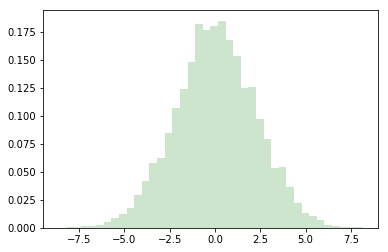

In [13]:
decoder_true_path = glob.glob(f'{OUTPUT}/synthetic/decoder_true.pth')[0]
decoder_true = torch.load(decoder_true_path, map_location=DEVICE)

for name, param in decoder_true.named_parameters():
    print(name, param.data, '\n')
    
generated_true_x = toynn.generate_from_decoder(decoder_true, N_SAMPLES)

fig, ax = plt.subplots()
ax = toyvis.plot_data(generated_true_x, color='green', label='from decoder true', ax=ax)

# Get synthetized data and corresponding MLE

In [14]:
train_w_mle, train_min_neg_ll = min_neg_ll()
val_w_mle, val_min_neg_ll = min_neg_ll(val=True)

train_w_elbo, train_elbo_neg_ll = elbo_neg_ll()
val_w_elbo, val_elbo_neg_ll = elbo_neg_ll(val=True)

# Training set
print('The maximum likelihood estimator on this train dataset is:')
print(train_w_mle)

print('The corresponding value for the negative log-likelihood for the training set is:')
print(train_min_neg_ll)

print('The w_elbo estimator on this train dataset is:')
print(train_w_elbo)

print('The corresponding value for the negative log-likelihood for the training set is:')
print(train_elbo_neg_ll)

print('\n')

# Validation set

print('The maximum likelihood estimator on this val dataset is:')
print(val_w_mle)

print('The corresponding value for the negative log-likelihood for the validation set is:')
print(val_min_neg_ll)

print('The w_elbo estimator on this validation dataset is:')
print(val_w_elbo)

print('The corresponding value for the negative log-likelihood for the validation set is:')
print(val_elbo_neg_ll)

The maximum likelihood estimator on this train dataset is:
[1.975533]
The corresponding value for the negative log-likelihood for the training set is:
[2.2138348]
The w_elbo estimator on this train dataset is:
[1.2377486]
The corresponding value for the negative log-likelihood for the training set is:
[2.3834476]


The maximum likelihood estimator on this val dataset is:
[2.0159473]
The corresponding value for the negative log-likelihood for the validation set is:
[2.2300212]
The w_elbo estimator on this validation dataset is:
[1.2377486]
The corresponding value for the negative log-likelihood for the validation set is:
[2.3834476]


# Comparison of Convergences

In [27]:
from_epoch = 1
to_epoch = 50

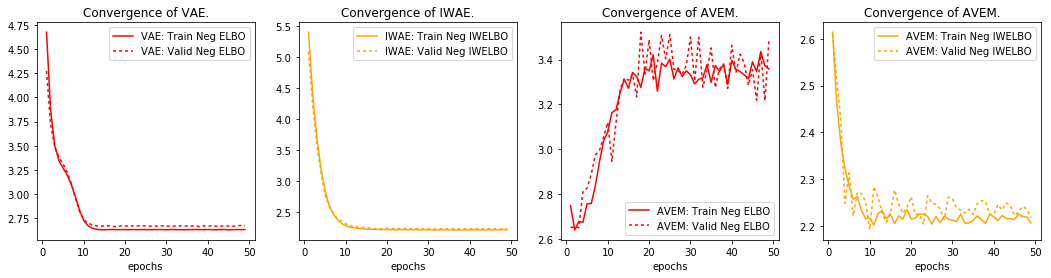

In [28]:
color_dict = {'neg_elbo': 'red', 'neg_iwelbo': 'orange'}

def plot_convergence(ax, algo_name, crit_name):
    ax = plot_criterion(ax, algo_name=algo_name, crit_name=crit_name, mode='train', 
                    from_epoch=from_epoch, to_epoch=to_epoch, color=color_dict[crit_name])
    ax = plot_criterion(ax, algo_name=algo_name, crit_name=crit_name, mode='val', 
                    from_epoch=from_epoch, to_epoch=to_epoch, color=color_dict[crit_name], dashes=True)
    ax.set_title(f'Convergence of {algo_strings[algo_name]}.')
    return ax

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 4))

ax = axes[0]
ax = plot_convergence(ax, 'vae', 'neg_elbo')

ax = axes[1]
ax = plot_convergence(ax, 'iwae', 'neg_iwelbo')

ax = axes[2]
ax = plot_convergence(ax, 'vem', 'neg_elbo')
ax = axes[3]
ax = plot_convergence(ax, 'vem', 'neg_iwelbo')

Text(0.5, 1.0, 'Convergence in parameters (Zoom)')

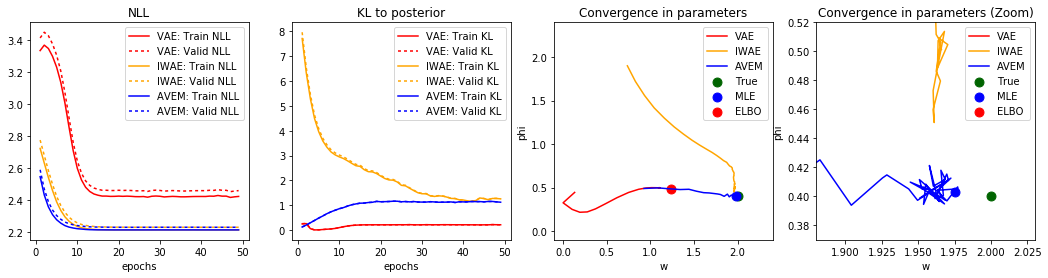

In [29]:
w_opt = 2.
phi_opt = w_opt / (1 + w_opt ** 2)

w_mle = train_w_mle
phi_mle = w_mle / (1 + w_mle ** 2)

w_elbo = train_w_elbo
phi_elbo = w_elbo / (1 + w_elbo ** 2)

def plot_weights_landscape(ax, from_epoch=0, to_epoch=1000):
    ax = plot_weights(ax, algo_name='vae', from_epoch=from_epoch, to_epoch=to_epoch, color='red')
    ax = plot_weights(ax, algo_name='iwae', from_epoch=from_epoch, to_epoch=to_epoch, color='orange')
    ax = plot_weights(ax, algo_name='vem', from_epoch=from_epoch, to_epoch=to_epoch, color='blue')

    ax.scatter(w_opt, phi_opt, marker = 'o', s=80, color='darkgreen', label='True')
    ax.scatter(w_mle, phi_mle, marker = 'o', s=80, color='blue', label='MLE')
    ax.scatter(w_elbo, phi_elbo, marker = 'o', s=80, color='red', label='ELBO')

    ax.set_xlabel('w')
    ax.set_ylabel('phi')
    ax.legend()
    return ax

algo_color_dict = {'vae': 'red', 'iwae': 'orange', 'vem': 'blue'}

def plot_nll(ax, algo_name):
    ax = plot_criterion(ax, algo_name=algo_name, crit_name='neg_loglikelihood', mode='train', 
                    from_epoch=from_epoch, to_epoch=to_epoch, color=algo_color_dict[algo_name])
    ax = plot_criterion(ax, algo_name=algo_name, crit_name='neg_loglikelihood', mode='val', 
                    from_epoch=from_epoch, to_epoch=to_epoch, color=algo_color_dict[algo_name], dashes=True)
    return ax

def plot_kl(ax, algo_name):
    ax = plot_kl_posterior(ax, algo_name=algo_name, mode='train',
                      from_epoch=from_epoch, to_epoch=to_epoch, color=algo_color_dict[algo_name], dashes=False)
    ax = plot_kl_posterior(ax, algo_name=algo_name, mode='val',
                      from_epoch=from_epoch, to_epoch=to_epoch, color=algo_color_dict[algo_name], dashes=True)
    
    return ax

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 4))

ax = axes[0]
ax = plot_nll(ax, 'vae')
ax = plot_nll(ax, 'iwae')
ax = plot_nll(ax, 'vem')
ax.set_title('NLL')

ax = axes[1]
ax = plot_kl(ax, 'vae')
ax = plot_kl(ax, 'iwae')
ax = plot_kl(ax, 'vem')
ax.legend()
ax.set_title('KL to posterior')

ax = axes[2]
ax = plot_weights_landscape(ax, from_epoch=from_epoch, to_epoch=to_epoch)
ax.set_xlim((-0.1, 2.4)) 
ax.set_ylim((-0.1, 2.4))
ax.legend()
ax.set_title('Convergence in parameters')

ax = axes[3]
ax = plot_weights_landscape(ax, from_epoch=from_epoch, to_epoch=to_epoch)

ax.set_xlim((1.88, 2.03)) 
ax.set_ylim((0.37, 0.52))
ax.set_title('Convergence in parameters (Zoom)')

# Comparison of data distribution and posterior distributions

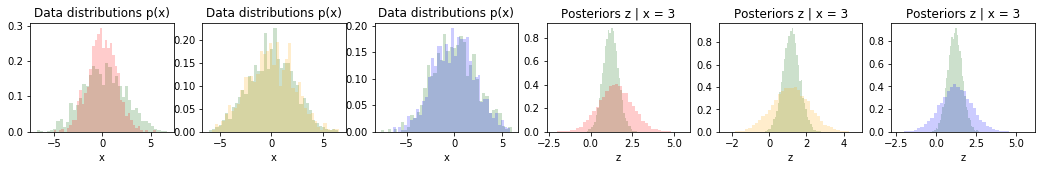

In [30]:
algo_name = 'iwae'

def plot_data_distribution(ax, algo_name='vae'):
    n_samples = 1000
    
    decoder_path = glob.glob(f'{OUTPUT}/train_{algo_name}/models/decoder.pth')[0]
    decoder = torch.load(decoder_path, map_location=DEVICE)
    
    generated_true_x = toynn.generate_from_decoder(decoder_true, n_samples)
    generated_x = toynn.generate_from_decoder(decoder, n_samples)

    toyvis.plot_data(generated_true_x, color='darkgreen', ax=ax)
    toyvis.plot_data(generated_x, color=algo_color_dict[algo_name], ax=ax)
    ax.set_title('Data distributions p(x)')
    ax.set_xlabel('x')
    return ax

def plot_posterior(ax, algo_name='vae'):
    n_to_sample = 10000
    w_true = 2
    x = 3
    
    encoder_path = glob.glob(f'{OUTPUT}/train_{algo_name}/models/encoder.pth')[0]
    encoder = torch.load(encoder_path, map_location=DEVICE)
    
    weight_phi = encoder.fc1.weight[[0]]    
    weight_phi = weight_phi.detach().cpu().numpy()
    weight_phi = np.abs(weight_phi)
    
    true_loc = w_true / (w_true ** 2 + 1) * x
    true_scale = 1/ np.sqrt((1 + w_true ** 2))
    z_true_posterior = np.random.normal(loc=true_loc, scale=true_scale, size=(n_to_sample, 1))
    z_opt_posterior = np.random.normal(loc=true_loc, scale=1, size=(n_to_sample, 1))
    z_encoder = np.random.normal(loc=weight_phi*x, scale=1, size=(n_to_sample, 1)) 
                        
    ax = toyvis.plot_data(z_true_posterior, color='darkgreen', ax=ax)
    # ax = toyvis.plot_data(z_opt_posterior, color='blue', ax=ax)
    ax = toyvis.plot_data(z_encoder, color=algo_color_dict[algo_name], ax=ax)
    ax.set_title('Posteriors z | x = 3')
    ax.set_xlabel('z')
    return ax

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(18, 2))

ax = axes[0]
ax = plot_data_distribution(ax, 'vae')

ax = axes[1]
ax = plot_data_distribution(ax, 'iwae')

ax = axes[2]
ax = plot_data_distribution(ax, 'vem')

ax = axes[3]
ax = plot_posterior(ax, 'vae')

ax = axes[4]
ax = plot_posterior(ax, 'iwae')

ax = axes[5]
ax = plot_posterior(ax, 'vem')

# Comparison of times

In [31]:
def print_average_time(algo_name='vae'):
    losses_path = glob.glob(f'{OUTPUT}/train_{algo_name}/val_losses.pkl')[0]
    losses_all_epochs = pickle.load(open(losses_path, 'rb'))
    
    times = [loss['total_time'] for loss in losses_all_epochs]
    print(np.mean(times))
    
print_average_time('vae')
print_average_time('iwae')
print_average_time('vem')

0.06083973050117493
0.0656246930360794
0.13609812259674073


# Print pipeline logs

In [160]:
pattern = 'logs'
logs = []
for filename in os.listdir(OUTPUT):
    if re.search(pattern, filename):
        logs.append(filename)

print('Found %d log files.' % len(logs))
        
for filename in logs:
    path = os.path.join(OUTPUT, filename)
    print('\n-- Log file: %s\n' % filename)
    with open(path, 'r') as f:
        message = f.read()
    print(message)

Found 1 log files.

-- Log file: logs2019-05-17 22:05:22.503695.txt

2019-05-17 22:05:22,503 root         INFO     start
2019-05-17 22:05:22,518 luigi        INFO     logging configured by default settings
2019-05-17 22:05:22,542 luigi-interface DEBUG    Checking if RunAll() is complete
2019-05-17 22:05:22,543 luigi-interface DEBUG    Checking if Report() is complete
2019-05-17 22:05:22,543 luigi-interface INFO     Informed scheduler that task   RunAll__99914b932b   has status   PENDING
2019-05-17 22:05:22,544 luigi-interface DEBUG    Checking if TrainVAE() is complete
2019-05-17 22:05:22,544 luigi-interface DEBUG    Checking if TrainIWAE() is complete
2019-05-17 22:05:22,545 luigi-interface DEBUG    Checking if TrainVEM() is complete
2019-05-17 22:05:22,545 luigi-interface INFO     Informed scheduler that task   Report__99914b932b   has status   PENDING
2019-05-17 22:05:22,546 luigi-interface DEBUG    Checking if MakeDataSet() is complete
2019-05-17 22:05:22,546 luigi-interface INFO  